# Installation and Setup

In [79]:
# Pyspark
!pip install pyspark
!PYSPARK_HADOOP_VERSION=3 pip install pyspark
!PYSPARK_HADOOP_VERSION=3 pip install pyspark -v
!pip install pyspark-connect


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Using pip 24.0 from /opt/homebrew/lib/python3.10/site-packages/pip (python 3.10)

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [80]:
# Polars
!pip install polars


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [81]:
# Pandas
!pip install pandas


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [ ]:
!pip install matplotlib
!pip install mplfinance
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [124]:
df_old, df = loader.load('polars')
df_old['Timestamp'][-1], df['Timestamp'][-1]

(1757289420.0, datetime.datetime(1970, 1, 1, 0, 29, 17, 289420))

In [126]:
loader.load('pandas')

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
1,2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2,2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
3,2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
4,2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
7196792,2025-09-07 23:53:00,111152.00,111154.00,111117.00,111154.00,2.995635
7196793,2025-09-07 23:54:00,111154.00,111154.00,111123.00,111124.00,1.144068
7196794,2025-09-07 23:55:00,111129.00,111153.00,111129.00,111145.00,0.195623
7196795,2025-09-07 23:56:00,111139.00,111144.00,111139.00,111140.00,0.046351


# Benchmark Pandas v/s Polars v/s Pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("DataFrameLoader").getOrCreate()
# try:
#     spark.stop()
# except:
#     pass

In [ ]:
import pandas as pd
import polars as pl
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, year, mean as Fmean
import matplotlib.pyplot as plt
import time

class DataFrameLoader:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        try:
            self.spark = SparkSession.builder.appName("DataFrameLoader").getOrCreate()
        except:
            self.spark = None

    def load(self, library='pandas'):
        library = library.lower()

        if library == 'pandas':
            df = pd.read_csv(self.csv_path)
            # Keep Timestamp as epoch seconds
            return df

        elif library == 'polars':
            df = pl.read_csv(self.csv_path)
            # Keep Timestamp as Int64 (epoch seconds)
            if "Timestamp" in df.columns and df["Timestamp"].dtype not in [pl.Int64, pl.Float64]:
                df = df.with_columns(pl.col("Timestamp").cast(pl.Int64))
            return df

        elif library == 'pyspark':
            if self.spark is None:
                raise ValueError("Spark session not initialized")
            df = self.spark.read.csv(self.csv_path, header=True, inferSchema=True)
            # Keep Timestamp as epoch seconds (LongType)
            if "Timestamp" in df.columns:
                df = df.withColumn("Timestamp", col("Timestamp").cast("long"))
            return df

        else:
            raise ValueError("Unsupported library. Choose 'pandas', 'polars', or 'pyspark'.")

    def benchmark(self):
        libraries = ['pandas', 'polars', 'pyspark']
        timings = {lib: {} for lib in libraries}

        for lib in libraries:
            start = time.time()
            df = self.load(lib)
            timings[lib]['read'] = time.time() - start

            start = time.time()
            if lib == 'pyspark':
                df.show(5, truncate=False)
            else:
                df.head()
            timings[lib]['head'] = time.time() - start

            start = time.time()
            if lib == 'pandas':
                _ = df[df['Close'] > 50000]
            elif lib == 'polars':
                _ = df.filter(pl.col("Close") > 50000)
            elif lib == 'pyspark':
                _ = df.filter(df["Close"] > 50000).count()
            timings[lib]['filter'] = time.time() - start

            start = time.time()
            # ---------- GroupBy Year ----------
            if 'Timestamp' in df.columns:
                if lib == 'pandas':
                    # convert epoch to year on the fly
                    df['Year'] = pd.to_datetime(df['Timestamp'], unit='s').dt.year
                    _ = df.groupby('Year')['Close'].mean()
                elif lib == 'polars':
                    df = df.with_columns(
                        ((pl.col("Timestamp") / 31556952 + 1970).cast(pl.Int64)).alias("Year")
                    )  # rough approximation: seconds in a year
                    _ = df.group_by("Year").agg(pl.mean("Close"))
                elif lib == 'pyspark':
                    df = df.withColumn("Year", year(from_unixtime(col("Timestamp"))))
                    _ = df.groupBy("Year").agg(Fmean("Close"))
            timings[lib]['groupby_mean'] = time.time() - start

        # ---------- Plot ----------
        ops = ['read', 'head', 'filter', 'groupby_mean']
        x = range(len(libraries))
        plt.figure(figsize=(12,6))

        for idx, op in enumerate(ops):
            times = [timings[lib][op] for lib in libraries]
            plt.bar([i + idx*0.2 for i in x], times, width=0.2, label=op)

        plt.xticks([i + 0.3 for i in x], libraries)
        plt.ylabel('Time (seconds)')
        plt.title('CSV Benchmark: Pandas vs Polars vs PySpark (Epoch Timestamp)')
        plt.legend()
        plt.show()

        return timings

# LOAD AND BENCHMARK
csv_file_path = "btcusd_1-min_data.csv"
loader = DataFrameLoader(csv_file_path)


#### It can be seen that for a dataset size of approx 350MB, the overhead of pyspark is not justified and leads to worse comparision compared to Polars and even Pandas

+----------+----+----+----+-----+------+
|Timestamp |Open|High|Low |Close|Volume|
+----------+----+----+----+-----+------+
|1325412060|4.58|4.58|4.58|4.58 |0.0   |
|1325412120|4.58|4.58|4.58|4.58 |0.0   |
|1325412180|4.58|4.58|4.58|4.58 |0.0   |
|1325412240|4.58|4.58|4.58|4.58 |0.0   |
|1325412300|4.58|4.58|4.58|4.58 |0.0   |
+----------+----+----+----+-----+------+
only showing top 5 rows


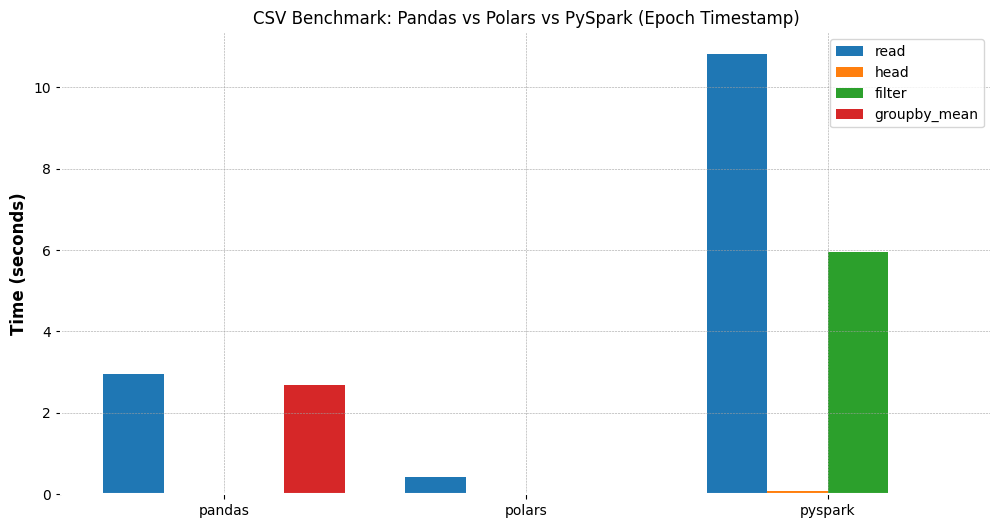

Benchmark results (in seconds):
pandas {'read': 2.9465601444244385, 'head': 0.00018596649169921875, 'filter': 0.03913307189941406, 'groupby_mean': 2.677454948425293}
polars {'read': 0.41265392303466797, 'head': 6.389617919921875e-05, 'filter': 0.007007122039794922, 'groupby_mean': 0.03651690483093262}
pyspark {'read': 10.807034015655518, 'head': 0.07787418365478516, 'filter': 5.950787782669067, 'groupby_mean': 0.006757259368896484}


In [ ]:
# BENCHMARK
benchmark_results = loader.benchmark()
print("Benchmark results (in seconds):")
for lib, results in benchmark_results.items():
    print(lib, results)